# MCMC 简介

前两篇笔记隐藏了PyMC3的内部机制，更一般地说，就是隐藏了Markov Chain Monte Carlo（MCMC）的内部机制。本文就来简单讨论下MCMC。

了解MCMC的过程可以帮助深入了解算法是否已收敛（收敛到什么？）。另外，我们将理解为什么要从后验中返回成千上万个样本作为解决方案，乍一看这可能很奇怪。

参考资料除了这本 [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) 之外，还有:

- [告别数学公式，图文解读什么是马尔可夫链蒙特卡罗方法（MCMC)](https://zhuanlan.zhihu.com/p/32982140)

## The Bayesian landscape

当我们设置N个未知数的贝叶斯推断问题时，我们隐式地创建了一个 N维的存在先验分布的空间。与空间相关联的是一个附加维度，我们可以将其描述为位于空间顶部的曲面或曲线，它反映了特定点的先验概率。空间的表面由我们的先验分布定义。例如，如果我们有两个未知数p1 和 p2，并且两者的先验是 Uniform（0 ，5 ），那么创建的空间是一个长度为5的正方形，并且表面是一个位于正方形顶部的平面（表示每个点的可能性均等）。

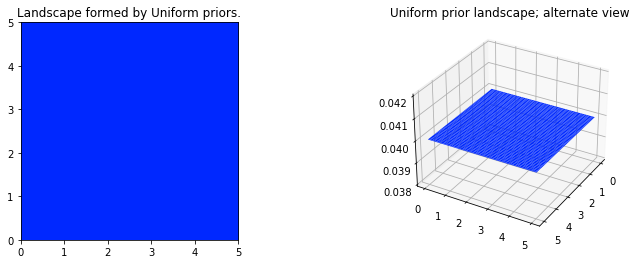

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");

或者，如果两个先验是 Exp（3 ） 和 Exp（10 ），则该空间在二维平面上均为正数，先验的surface看起来像是从点（0,0）开始流过正数的瀑布。

下图将其可视化。颜色越深越红，分配给该位置的先验概率就越高。相反，蓝色较深的区域表示我们的先验对该位置分配的概率非常低。

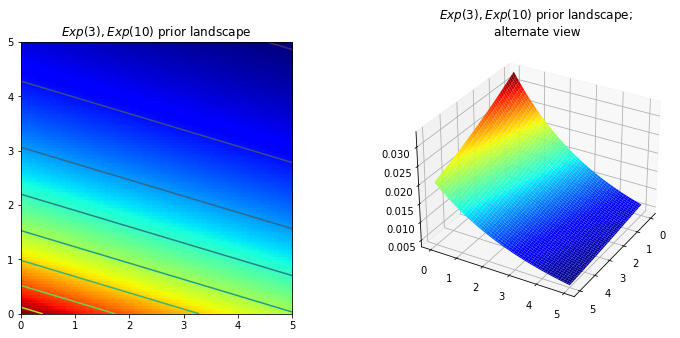

In [2]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

这些是2D空间中的简单示例，我们的大脑可以很好地理解曲面。实际上，我们的先验产生的空间和曲面的维度可能要大得多。

如果这些表面描述了我们在未知数上的先验分布，那么在融合观测数据X之后，空间将会发生什么？数据X不会改变空间，但会通过伸缩先验曲面的构造来改变空间曲面以反映真实参数可能存在的位置。更多的数据意味着更多的伸缩，并且与新形成的形状相比，我们的原始形状会变得微不足道。数据越少，我们保留原始形状就更多。无论如何，所得曲面都描述了后验分布。

不幸的是，我们不可能在高维可视化它。对于二维而言，数据实质上是推高原始表面以形成高耸的山脉。可以通过先验概率分布观测数据上升的趋势检查某些区域的后验概率。先验概率越小意味着阻力越大。因此，在上述双指数先验情况下，在（0,0）角附近喷出一座山（或多座山）的可能将比在接近（5,5）喷出山的可能高得多，因为（5,5）附近的低先验概率表明阻力更大。峰值反映了可能找到真实参数的后验概率。值得注意的是，如果先验概率已分配为0，则不会在此分配后验概率。

假设上述先验代表两个泊松分布不同的参数 λ。现在我们观察到一些数据点并重新可视化整个landscape（TODO: 这块似乎有点问题，但是主要是为了明确逻辑，里面具体代码细节不用管）：

In [4]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 1): [[2 1]]


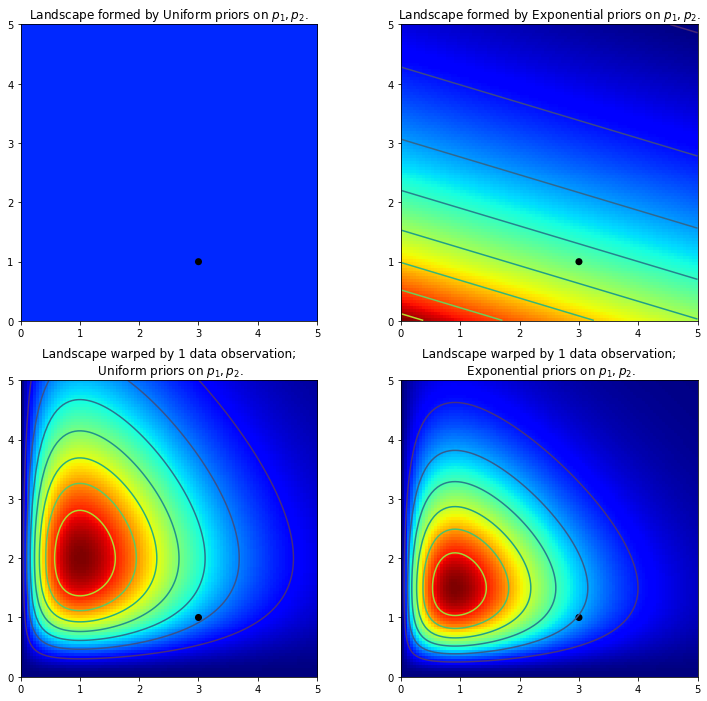

In [5]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)

plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);

左边的图是 均匀（0 ，5 ）先验的 变形，右图是具有指数先验的变形。请注意，尽管两种情况下观察到的数据相同，但后验看起来彼此不同。

请注意，指数先验（右下图）在该图右上角的值上只放置了很少的后验权重：这是因为先验值在此处没有太大的权重。另一方面，均匀先验很乐意将后后验权重放在右上角，因为先验在右上角放置更多的权重。

还要注意，在指数情况下，最高点（对应最暗的红色）朝（0,0）倾斜，这是指数先验将更多先验权重放在（0,0）角的结果。

黑点代表真实参数。即使只有1个采样点，山脉也会尝试包含true参数。当然，采用1个样本大小进行推断是非常简单的，选择如此小的样本大小仅是说明性的。

尝试将样本大小更改为其他值（尝试2,5,10,100？...），并观察我们的后验“山”如何变化，是一个很棒的练习。

下面进一步了解MCMC。

## 蒙特卡罗模型和马尔可夫链

如前所述，如果我们的先验分布和可能性分布表现得很复杂，这时候使用复杂的形状建模数据或先验信念时是最精确的。存在一些后验分布给出了每个参数值的可能性。但是很难看出完整的分布，也无法用分析解决。于是这就需要MCMC方法了。

MCMC允许我们估计后验分布的形状，以防我们无法直接计算。为了理解MCMC方法是如何工作的，先简单补充一些蒙特卡罗模型，和马尔可夫链的内容。

蒙特卡罗模型只是一种重复生成随机数字来估计固定参数的方法。通过生成随机数字并对其进行计算，蒙特卡罗法给出一个参数的近似值，但是却不能直接直接计算。比如用于估算不规则区域的面积（投针实验，比较经典就不多废话了）。

通过生成大量的随机数，它们可以用来模拟非常复杂的过程。在实践中，它们可以用来预测天气，或估计选举结果。

马尔可夫链由概率相互关联的序列组成，每一事件来自一组结果，每个结果根据一组固定的概率确定下一个结果。

马尔可夫链的一个重要特征是“无记忆”：预测下一个事件所需要的所有信息都能在当前状态中找到，从历史事件中也找不到新的信息。但现实中很少有东西能以这种方式工作。不过，马尔可夫链是理解世界的有力方式。

在19世纪，钟形曲线被看做自然界中常见的模式。例如，我们发现人类的身高就是遵循这样的曲线。弗朗西斯·高尔顿（Francis Galton）在一块竖直放置的板子上钉上交错排列的钉子，让大理石从板的上端自由下落，最终落至板底端的某一格子中，最终重现了正态分布曲线。

俄罗斯数学家和神学家帕维尔·涅克拉索夫（Pavel Nekrasov）认为，钟形曲线甚至大数定律只不过是儿童游戏和小把戏的产物，这里的每一事件都是完全独立的。他认为现实世界中相互依存的事物，比如人的行为，不符合数学模型或分布。

马尔可夫链的命名者安德烈·马尔科夫（Andrey Markov）试图证明非独立事件也可能符合数学模型。他最著名的案例之一就是要从一部俄罗斯诗歌作品中输出数千个“两字母对”（two-character pairs）。利用这些对，他计算了每一字母的条件概率。也就是说，给定前面的字母或空格，就能预测下一个字母是A还是T，或是一个空格。利用这些概率，马尔可夫可以模拟任意长的字符序列，这就是马尔可夫链。尽管前几个字母很大程度上取决于起始字母的选择，但是马尔可夫表明，从长远看来，字母的分布也遵循一种模式。因此，即使是相互依赖的事件，如果它们受到固定概率的影响，也将遵循平均水平的模式。

举一个更有用的例子。假如你的房子有五个房间，分别是卧室、卫生间、客厅、餐厅和厨房。让我们收集一些数据，假设不管你在任何时候处于任何房间，我们都能推测出你下一个可能进入的房间，例如，如果你在厨房，你将有30%的可能性留在厨房，30%的可能性进入餐厅，20%的可能性进入客厅，10%的可能性进入卧室，然后有10%的可能性去到卫生间。利用每个房间的一组概率，我们可以构建一个“你将去到的房间”链。

如果我们想要预测这个人在离开厨房后会在哪个房间中待一小会儿的概率，那么做一些预测是有用的。但是由于我们的预测只是基于对房间里一个人的观察，所以有理由认为这种预测表现的不会很好。例如，假设一个人从卧室出来后进入了卫生间，那么他更有可能直接回到卧室。但如果是从厨房出来的话，就不一定回到卧室了。所以马尔科夫的成果不一定适用于现实世界。

然而，将马尔可夫链进行数千次迭代后，确实能够长期预测你可能会进入那个房间。更重要的是，这个预测并没有受到这人最初处于哪个房间的影响！简单地说：在某一时间某人处于家里哪个位置并不重要。所以马尔可夫链这个看似在几个时期内对随机变量建模的不合理方法，可以用来**计算该变量的长期趋势**。

我们知道后验分布是在先验分布和可能性分布范围之内的，但是由于种种原因，我们不能直接计算它。使用MCMC方法，我们将有效地**从后验分布中抽取样本**，然后**计算样本中的平均值**。

首先，**MCMC方法要选择一个随机参数。模型会继续产生随机值（这是蒙特卡罗的一部分），但要根据一些规则来确定什么是一个好的参数值。对于一对参数值，通过计算每个值能解释数据的可能性，将有可能计算哪个参数值更好。如果一个随机生成的参数比上一个参数更好，则将根据好的程度确定一定概率，并将其添加到参数值链中（这是马尔可夫链的一部分）**。

为了更直观地解释这一点，举一个新例子：人类身高分布在某一特定值所代表的观察该值的概率。X轴代表的参数值显示出的高低不同的概率表现在Y轴上。图中黑色虚线是上帝视角的后验分布。

![](pictures/v2-41fcd459d8fe1ce20e732f738b2dbd31_720w.png)

对于单个参数，MCMC方法沿着X轴开始随机采样：

![](pictures/v2-20f316f3cf43bff2951de66366833219_720w.png)

由于随机样本受到固定概率的影响，它们往往会在我们感兴趣的参数的概率最高的地方进行收敛（蓝点只代表任意时间点之后的样本，预计会出现收敛。注意：为了说明，点是垂直叠加放置的）：

![](pictures/v2-4a03130c6f752dedafa3f181e66e0d76_720w.png)

收敛之后，MCMC抽样产生了一组来自后验分布的样本点。在这些点周围绘制直方图，并计算任何您喜欢的统计数据。

![](pictures/v2-1b63b2b848e796e72baf1ffbd7cb2568_720w.png)

根据MCMC模型生成的样本集计算出的任何数据是我们**对该真实后验分布数据的最佳猜测**。

MCMC方法也可以用来估计多个参数的后验分布，比如人的身高和体重。对于n个参数，在n维空间中存在高概率的区域，其中某些参数值能更好地解释观察到的数据。因此，可以认为MCMC方法是**在概率空间中随机采样后估计后验分布**。

> MCMC方法是用来在概率空间，通过随机采样估算兴趣参数的后验分布。

如上所述，我们应该探索由先验表面产生的变形后验空间，并观察数据以找到后验山脉。

但是，我们不能简单地直接搜索空间：任何计算机科学家都会说遍历N维空间是困难的：随着N的增加，空间的大小会迅速膨胀（请参阅[维度灾](https://en.wikipedia.org/wiki/Curse_of_dimensionality)）。

我们有什么希望找到这些隐藏的山脉？MCMC背后的想法是**对空间进行智能搜索**。说“搜索”意味着我们正在寻找一个特定的点，因为我们实际上正在寻找一个广阔的山脉，所以这可能并不准确。

**MCMC从后验分布返回样本而不是返回分布本身**。将我们的山比喻延伸到极限，MCMC执行的任务类似于反复询问“我发现的这个卵石有多大可能来自我正在寻找的山峰？”，并通过返回数千个被接受的卵石来完成该任务，以期进行重建真实的山。在MCMC和PyMC3术语中，返回的“卵石”序列是样本，它们一起被称为traces。

当说MCMC进行智能搜索时，意思是说MCMC有望朝着较高的后验概率区域收敛。MCMC通过探索附近的位置并进入较高概率的区域来做到这一点。同样，也许“收敛”不是描述MCMC进程的准确术语。“收敛”通常意味着朝着空间中的某个点移动，但是MCMC朝着空间中的一个更大区域移动并随机走入该区域，从该区域中采集样本。

为什么要成千上万个样本？

最主要的原因可能是我们可以轻松地使用“大数定律”来解决不这样就很难解决的问题。后面会继续讨论这点。通过成千上万个样本，我们可以通过将它们组织成直方图来重建后验曲面。

有很多执行MCMC的算法。这些算法中的大多数都可以如下概括地表示：

1. 从当前位置开始。
2. 提议搬到新位置（调查您附近的卵石）。
3. 根据位置对数据的依从性和先验分布来接受/拒绝新位置（询问卵石是否可能来自山峰）。
4. 如果您接受：移至新位置。返回步骤1。否则：不要移动到新位置。返回步骤1。
5. 经过大量迭代后，返回所有接受的位置。

这样，我们就朝着存在后验分布的区域大体上移动，并在旅途中少量地收集样本。一旦达到后验分布，我们就可以轻松收集样本，因为它们很可能全部属于后验分布。

如果MCMC算法的当前位置处于极低概率的区域中（通常是算法开始时的情况（通常在空间中的随机位置），则算法将在可能不位于后部的位置移动）但比附近的其他地方都要好。因此，算法的第一步不反映后验。

在上述算法的伪代码中，请注意，只有当前位置很重要（仅在当前位置附近调查新位置）。我们可以将此属性描述为无记忆性，即算法不关心它如何到达其当前位置，而只关心它在那里。

除了MCMC，还有其他方法可用于确定后验分布。我暂时用不到，就不提及了。

下面看一个例子来进一步理解。

假设我们得到以下数据集：

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


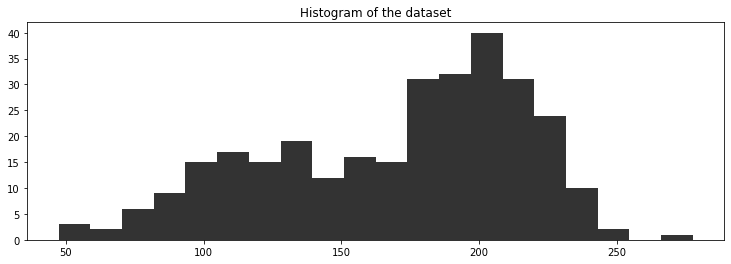

In [6]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

数据表明什么？看来数据具有双峰形式，也就是说，它似乎有两个峰，一个峰在120附近，另一个峰在200附近。在该数据集中可能有两个聚类。

该数据集是上一章中数据生成建模技术的一个很好的例子。我们可以提出如何创建数据的建议。我建议使用以下数据生成算法：

1. 对于每个数据点，有概率p选择聚类1 ，否则选择集群2。
2. 从正态分布中提取带有参数的随机变量 μi 和 σi ，其中i是在步骤1中选择的。
3. 重复。

该算法将产生与观察到的数据集相似的效果，因此我们选择此模型作为模型。当然，我们不知道p或正态分布的参数。因此，我们必须推断或学习这些未知数。

表示正态分布 N0 和 N1（从0开始变量索引）。当前均具有未知的均值和标准差，表示为μi 和 σi，i= 0 ，1分别。特定数据点可以来自N0 或者 N1，并且我们假设数据点有 p 概率分配给 N0 。

将数据点分配给群集的一种适当方法是使用PyMC3 Categorical随机变量。它的参数是必须概率求和为1的ķ长度数组，并且其value属性是0到k − 1之间的整数。根据概率数组随机选择（在我们的情况下 k = 2）。我们不知道分配给集群1的概率是多少，即不知道先验，因此用uniform（0 ，1 ）。我们称这个为p1，因此属于簇2的概率为 p2= 1 -p1。

不幸的是，我们不能仅仅给[p1, p2]我们Categorical变量。PyMC3还要使用Theano来构建模型，因此我们需要theano.tensor.stack()结合使用p1 和 p2，变成可以理解的向量。 我们将此向量传递给Categorical变量以及testval参数，以使变量了解从何处开始。

In [7]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[1 1 1 1 0 0 0 0 0 0]


查看上面的数据集，我猜这两个法线的标准偏差是不同的。为了不知道标准偏差可能是什么，我们首先将它们建模为统一的0到100。我们将使用一行PyMC3代码将两个标准偏差都包括在模型中：

sds = pm.Uniform("sds", 0, 100, shape=2)

请注意，我们指定了shape=2：我们正在同时建模σ作为单个PyMC3变量。请注意，这不会引起两者之间的必要关系σs，这仅仅是为了简洁。

我们还需要在聚类中心指定先验。这些中心真的是μ这些正态分布中的参数。他们的先验可以用正态分布建模。查看数据，我知道两个中心可能在哪里—我可能会分别估计在120和190左右，尽管我对这些眼球估计并不十分自信。因此，我将设置μ0= 120 ，μ1个= 190 和 σ0=σ1个= 10。

请注意，我们如何在的上下文中继续构建模型Model()。这会自动将我们创建的变量添加到模型中。只要我们在这种情况下工作，我们就将使用已经定义的相同变量。

同样，我们在上下文中Model()所做的任何采样都只能在我们正在其上下文中工作的模型上进行。我们将通过定义采样方法（在本例中Metropolis()为我们的连续变量和ElemwiseCategorical()分类变量），告诉模型探索我们迄今为止定义的空间。我们将使用一起使用这些采样方法来探索空间sample( iterations, step )，其中iterations是您希望算法执行的步骤数，step也是处理这些步骤的方式。我们用我们的组合Metropolis()，并ElemwiseCategorical()为step和样品25000iterations下方。

到此，我们应该对MCMC有一个大致上的认识了，当然这还不够我们了解我们论文中看到的和参数估计等相关的内容。